In [9]:
suppressMessages(library(Signac))
suppressMessages(library(rtracklayer))
suppressMessages(library(openxlsx))
suppressMessages(library(dplyr))
suppressMessages(library(ggplot2))
suppressMessages(library(gridExtra))
source('validation_helper.R')
source('reproducibility_helper.R')
# from http://hgdownload.cse.ucsc.edu/goldenPath/hg19/liftOver/hg19ToHg38.over.chain.gz
# for liftover form hg19 to hg38
chain = import.chain("/projects/chang/scGRN/peak_gene/data/pbmc/hg19ToHg38.over.chain")


In [10]:
data_dir <- '/projects/chang/scGRN/analysis/real_data'
output_dir <- '/projects/chang/scGRN/analysis/real_data/output'
fig_dir <- '/projects/chang/scGRN/analysis/manuscript/figures'

In [11]:
res_list <- list()

ct <- 'CD14 Mono'
datasets <- 'PBMC_4_combined'

res_list_ct <- list()
res_list_ct[['proposed']] <- load_proposed(ct, datasets = datasets,
                                           fn_suffix = '_batch_adjusted',
                                           output_dir = output_dir)
res_list_ct[['SCENT']] <- load_SCENT(ct, n_sets=10,
                                     datasets = datasets,
                                     fn_suffix = '_batch_as_covar_adjusted_n_bootstrap_5000',
                                     output_dir = output_dir) 
res_list_ct[['Signac']] <- load_Signac(ct, datasets = datasets,
                                       fn_suffix = '_permu_adjusted',
                                      output_dir = output_dir)

res_list <- list()
res_list[[ct]] <- res_list_ct

# PCHiC

Consistency analysis with peak-gene pairs identified from promoter capture Hi-C on CD14 Monocytes from http://dx.doi.org/10.1016/j.cell.2016.09.037.

Data `DATA_S1/PCHiC_peak_matrix_cutoff5.tsv` was downloaded from the publication.

In [12]:
PCHiC <- read.table(sprintf('%s/data/validation/PBMC/PCHiC_peak_matrix_cutoff5.tsv', data_dir), header = T)
PCHiC_peaks_hg38 <- make_grange_hg19_to_38(PCHiC, 'oeChr', 'oeStart', 'oeEnd')

PCHiC_cts <- c('Mon', 'nB', 'tB', 'nCD4', 'tCD4', 'nCD8', 'tCD8')
pbmc_cts <- list()
pbmc_cts$Mon <- c('CD14 Mono')#, 'CD16 Mono')
pbmc_cts$nB <- c('B naive')
pbmc_cts$tB <- c("B naive", "B intermediate", "B memory")
pbmc_cts$nCD4 <- c('CD4 Naive')
pbmc_cts$tCD4 <- c("CD4 Naive", "CD4 TCM", "CD4 CTL", "CD4 TEM", "CD4 Proliferating")
pbmc_cts$nCD8 <- c("CD8 Naive")
pbmc_cts$tCD8 <- c("CD8 Naive", "CD8 TEM", "CD8 TCM", "CD8 Proliferating")


PCHiC_cts <- c('Mon', 'tCD4', 'nCD8', 'nCD4', 'tCD8')
new_cts <- c('CD14 Mono', 'CD4 TCM', 'CD8 Naive', 'CD4 Naive', 'CD8 TEM')
names(PCHiC_cts) <- new_cts

In [13]:
# with overlapped genes only
source('validation_helper.R')
res_PCHiC <- validate_with_assay(res_list, 1, ct,
                                 assay = 'PCHiC',
                                 p_cutoff = 0.1,
                                 assay_sig_cutoff = list(PCHiC = 5))

sum_df_PCHiC <- as.data.frame(res_PCHiC[1:5])
sum_df_PCHiC$method <- names(res_list[[1]])
sum_df_PCHiC$ct <- ct
sum_df_PCHiC$method <- factor(sum_df_PCHiC$method, 
                              levels = c('proposed', 'SCENT', 'Signac'),
                              labels = c('scMultiMap', 'SCENT', 'Signac'))

sum_df_PCHiC

pval,n_overlap,ratio,enr,n_assay,method,ct
<dbl>,<dbl>,<dbl>,<dbl>,<int>,<fct>,<chr>
4.889415e-12,431,0.2652308,1.321598,2445,scMultiMap,CD14 Mono
7.818306e-03,344,0.2236671,1.114493,2445,SCENT,CD14 Mono
8.240602e-03,129,0.2411215,1.201466,2445,Signac,CD14 Mono


In [15]:
#saveRDS(sum_df_PCHiC, sprintf('%s/results/PBMC_PCHiC.rds', output_dir))

# HiChIP

Consistency analysis with peak-gene pairs identified from H3K27ac HiChIP on CD14 Monocytes from https://doi.org/10.1038/s41588-020-00745-3.

Data `41588_2020_745_MOESM3_ESM.xlsx'` was downloaded from the publication.

In [16]:
HiChIP_res <- read.xlsx(sprintf('%s/data/validation/PBMC/41588_2020_745_MOESM3_ESM.xlsx', data_dir),
                         sheet = 'Supplementary Table 3')

interacting_peaks_hg19 <- HiChIP_res[-(1:2), c('X9', 'X10', 'X11', 'X3', 'X4', 'X14', 'X20', 'X22')]
colnames(interacting_peaks_hg19) <- c('chr', 'start', 'end', 'GeneID', 'GeneName', 'qval_CD14_Mono',
                                     'qval_CD4_Naive', 'qval_CD8_Naive')
for(i in which(grepl('qval', colnames(interacting_peaks_hg19)))){
    interacting_peaks_hg19[[i]] <- as.numeric(interacting_peaks_hg19[[i]])
}
interacting_peaks_hg38 <- make_grange_hg19_to_38(interacting_peaks_hg19)

cts_str <- c('CD14_Mono')
names(cts_str) <- 'CD14 Mono'

In [17]:
# q value cutoff=0.01
# https://www-nature-com.proxy.library.emory.edu/articles/s41588-020-00745-3#Sec10
# "Interactions having false discovery rate (FDR) < 0.01 are considered significant and reported as loop calls."
res_HiChIP <- validate_with_assay(res_list, 1, ct, p_cutoff=0.1, assay_sig_cutoff = list(HiChIP = 0.01))

sum_df_HiChIP <- as.data.frame(res_HiChIP[1:5])
sum_df_HiChIP$method <- names(res_list[[1]])
sum_df_HiChIP$ct <- ct
sum_df_HiChIP$method <- factor(sum_df_HiChIP$method, 
                               levels = c('proposed', 'SCENT', 'Signac'),
                               labels = c('scMultiMap', 'SCENT', 'Signac'))
sum_df_HiChIP



pval,n_overlap,ratio,enr,n_assay,method,ct
<dbl>,<dbl>,<dbl>,<dbl>,<int>,<fct>,<chr>
3.277844e-19,1642,0.4717035,1.172373,11201,scMultiMap,CD14 Mono
2.206513e-05,1538,0.4337281,1.077989,11201,SCENT,CD14 Mono
7.759573e-24,573,0.5530888,1.374649,11201,Signac,CD14 Mono


In [18]:
#saveRDS(sum_df_HiChIP, sprintf('%s/results/PBMC_HiChIP.rds', output_dir))

# eQTL

Consistency analysis with eQTL-gene pairs on CD14 Monocytes from 10.1126/science.1246949.

Data `1246949stables2.xlsx` was downloaded from the publication.


In [19]:
# http://dx.doi.org/10.1126/science.1246949
# B. P. Fairfax et al., Science 343, 1246949 (2014). DOI: 10.1126/science.1246949
eQTL_tab <- read.xlsx(sprintf('%s/data/validation//PBMC//1246949stables2.xlsx', data_dir), 
                                      sheet = 'B. Complete.cis.summary.all.ind') 
summary(eQTL_tab$Naive.FDR) # all gene-SNP pairs in this table are significant in Naive CD14 Monocytes, i.e. representing cis-eQTLs 

source('validation_helper.R')
res_eQTL <- validate_with_assay(res_list, 1, ct, 
                                pvar = 'adj_pval',
                                assay = 'eQTL',
                                p_cutoff = 0.1)

sum_df_eQTL <- as.data.frame(res_eQTL[1:5])
sum_df_eQTL$method <- names(res_list[[1]])
sum_df_eQTL$ct <- ct
sum_df_eQTL$method <- factor(sum_df_eQTL$method, 
                            levels = c('proposed', 'SCENT', 'Signac'),
                            labels = c('scMultiMap', 'SCENT', 'Signac'))

sum_df_eQTL

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   0.00    0.00    0.00    0.02    0.03    0.24  119487 

Discarding unchained sequences: chr23

Discarding unchained sequences: chr23

Discarding unchained sequences: chr23



pval,n_overlap,ratio,enr,n_assay,method,ct
<dbl>,<dbl>,<dbl>,<dbl>,<int>,<fct>,<chr>
1.581160e-23,252,0.1202864,1.831802,1137,scMultiMap,CD14 Mono
1.127167e-12,226,0.1020777,1.554508,1137,SCENT,CD14 Mono
7.582600e-17,103,0.1541916,2.348134,1137,Signac,CD14 Mono


In [ ]:
#saveRDS(sum_df_eQTL, sprintf('%s/results/PBMC_eQTL.rds', output_dir))

# Supplementary analysis: gradient boosting machine

In [20]:
res_list_ct <- list()
for(qu in c(0.85,0.9,0.95)){
    res_list_ct[[sprintf('quantile_%.2f', qu)]] <- load_GBM(ct, datasets = datasets, method_par = qu, output_dir = output_dir)
}
res_list <- list()
res_list[[ct]] <- res_list_ct

In [21]:
GBM_list <- list()
for(adata in c('PCHiC', 'HiChIP', 'eQTL')){
    GBM_list[[adata]] <- validate_with_assay(res_list, 1, ct, 
                                             assay = adata,
                                             pvar = 'pval',
                                             p_cutoff=0.1,
                                             assay_sig_cutoff = list(PCHiC = 5, HiChIP = 0.01))
}

Discarding unchained sequences: chr23

Discarding unchained sequences: chr23

Discarding unchained sequences: chr23



In [22]:
regular_df_list <- list(PCHiC = sum_df_PCHiC,
                       HiChIP = sum_df_HiChIP,
                       eQTL = sum_df_eQTL)

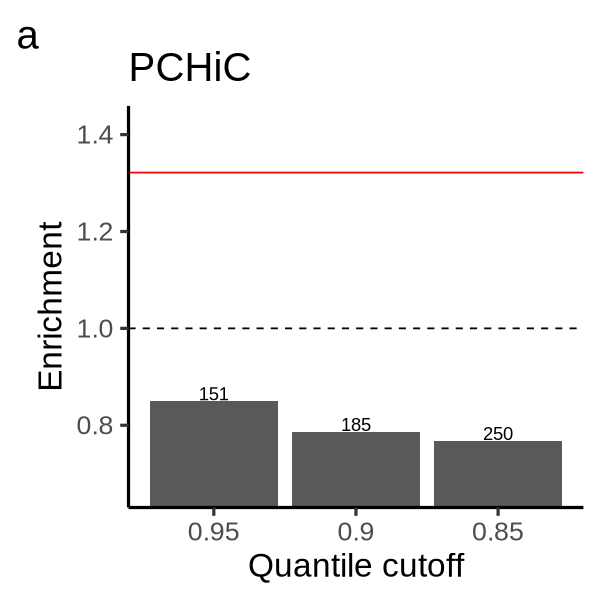

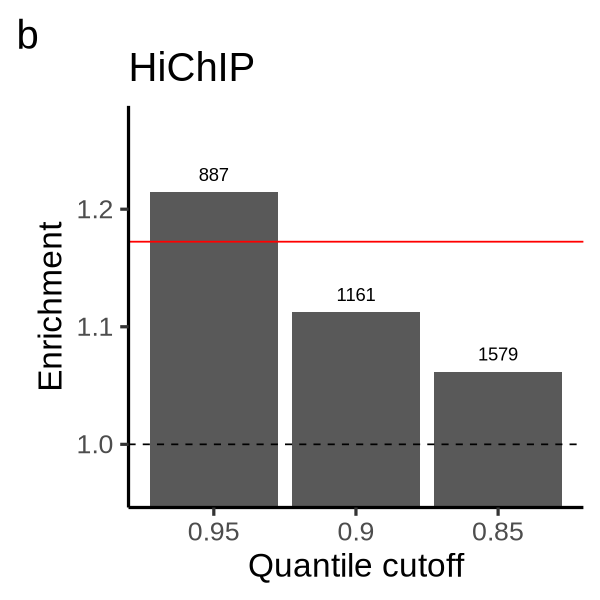

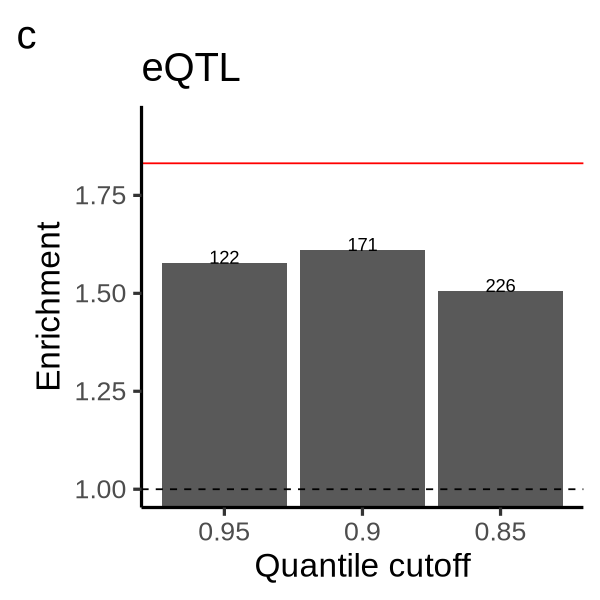

In [23]:
g_list <- list()
fig_letter <- c('a','b','c')
names(fig_letter) <- names(regular_df_list)
for(adata in names(regular_df_list)){
    df <- as.data.frame(GBM_list[[adata]][1:4])
    df$quantile <- c(0.85,0.9,0.95)

    options(repr.plot.width = 5, repr.plot.height = 5)
    g_list[[adata]] <- ggplot(df, 
                              aes(x = factor(quantile, levels = c(0.95,0.9,0.85), labels = c(0.95,0.9,0.85)), y = enr)) +
    geom_bar(stat = 'identity', position = 'dodge') +
    geom_text(aes(label = n_overlap), nudge_y = 0.015) +
    #geom_point(size = 2) +
    #geom_line() +
    #geom_bar(stat = 'identity', fill = 'white', color = 'black', width = 0.6) +
    geom_hline(yintercept = 1, linetype = 'dashed', color = 'black') +
    geom_hline(yintercept = regular_df_list[[adata]]$enr[regular_df_list[[adata]]$method == 'scMultiMap'], 
           color = 'red') +
    labs(x = 'Quantile cutoff', y = 'Enrichment',
        title = adata, tag = fig_letter[adata]) +
    coord_cartesian(ylim=c(min(1, min(df$enr)-0.1),
                           regular_df_list[[adata]]$enr[regular_df_list[[adata]]$method == 'scMultiMap']+0.1)) +
    theme_classic(base_size = 20) 
    print(g_list[[adata]])
    write.table(df, sprintf('../../scMultiMap_analysis/manuscript/Source Data/supplementary/figure_6%s.txt', fig_letter[adata]))
}

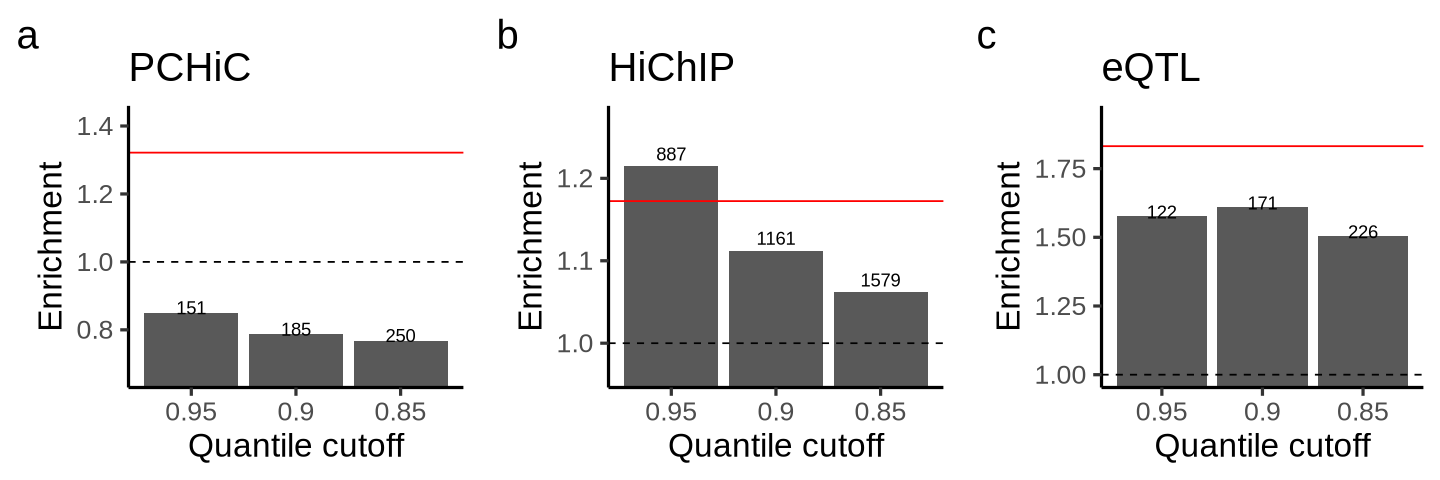

In [20]:
options(repr.plot.width = 12, repr.plot.height = 4)
g <- grid.arrange(grobs = g_list, nrow = 1)

In [21]:
ggsave(sprintf('%s/PBMC/consistency_GBM.pdf', fig_dir), g, width = 12, height = 4)